In [0]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import os
import tqdm
import keras
from keras.utils.np_utils import to_categorical
from keras_preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, image
from keras.applications.densenet import DenseNet169,preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.initializers import glorot_uniform
from keras.models import Model
from keras.layers import Dense, Activation, Input, Conv2D, Flatten, MaxPooling2D
from keras import regularizers
from keras.callbacks import EarlyStopping, TensorBoard

In [0]:
DATASET_DIR  = '/gdrive/My Drive/MURA/'
TRAIN_DIR    = DATASET_DIR + 'MURA-v1.2/train/'
VAL_DIR      = DATASET_DIR + 'MURA-v1.2/valid/'
PART_NAME    = 'XR_WRIST'
TRAIN_LABELS = DATASET_DIR+'train_labeled_studies.csv'
VAL_LABELS   = DATASET_DIR+'valid_labeled_studies.csv'

In [0]:
train_labels = pd.read_csv(TRAIN_LABELS, header = None)
val_labels   = pd.read_csv(VAL_LABELS, header = None)

In [0]:
tl = np.array(train_labels)


TypeError: ignored

In [0]:
train_labels = train_labels.set_index(0).T.to_dict('list')
val_labels = val_labels.set_index(0).T.to_dict('list')

AttributeError: ignored

In [0]:
train_labels

{'MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/': [1],
 'MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/': [1],
 'MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/': [1],
 'MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/': [1],
 'MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/': [1],
 'MURA-v1.1/train/XR_SHOULDER/patient00006/study1_positive/': [1],
 'MURA-v1.1/train/XR_SHOULDER/patient00007/study1_positive/': [1],
 'MURA-v1.1/train/XR_SHOULDER/patient00007/study2_negative/': [0],
 'MURA-v1.1/train/XR_SHOULDER/patient00008/study1_positive/': [1],
 'MURA-v1.1/train/XR_SHOULDER/patient00009/study1_positive/': [1],
 'MURA-v1.1/train/XR_SHOULDER/patient00010/study1_positive/': [1],
 'MURA-v1.1/train/XR_SHOULDER/patient00011/study1_positive/': [1],
 'MURA-v1.1/train/XR_SHOULDER/patient00012/study1_positive/': [1],
 'MURA-v1.1/train/XR_SHOULDER/patient00013/study1_positive/': [1],
 'MURA-v1.1/train/XR_SHOULDER/patient00014/study1_positive/': 

In [0]:
def prepare_data(labels, data_path, part, mode):
    BASE_DIR = 'MURA-v1.1/'+mode+'/'+part+'/'
    FILE_DIR = 'MURA-v1.2/'+mode+'/'+part+'/'
    df = pd.DataFrame(columns = ['Path', 'Label'])
    i=0
    for patient in os.listdir(data_path):
        for study in os.listdir(data_path+'/'+patient):
            for img in os.listdir(data_path+'/'+patient+'/'+study):
                if '_' not in list(img):
                    path = FILE_DIR+patient+'/'+study+'/'
                    label_path = BASE_DIR+patient+'/'+study+'/'
                    df.loc[i] = [path+img, int(labels[label_path][0])]
                    i=i+1
    return df
    

In [0]:
train_data = prepare_data(train_labels, TRAIN_DIR+PART_NAME, PART_NAME,'train')
val_data = prepare_data(val_labels, VAL_DIR+PART_NAME, PART_NAME,'valid')

In [0]:
train_data

,Path,Label
0,MURA-v1.2/train/XR_WRIST/patient02868/study1_n...,0
1,MURA-v1.2/train/XR_WRIST/patient02868/study1_n...,0
2,MURA-v1.2/train/XR_WRIST/patient02868/study1_n...,0
3,MURA-v1.2/train/XR_WRIST/patient02868/study1_n...,0
4,MURA-v1.2/train/XR_WRIST/patient02868/study1_n...,0
5,MURA-v1.2/train/XR_WRIST/patient07046/study1_p...,1
6,MURA-v1.2/train/XR_WRIST/patient07046/study1_p...,1
7,MURA-v1.2/train/XR_WRIST/patient07046/study1_p...,1
8,MURA-v1.2/train/XR_WRIST/patient07046/study1_p...,1
9,MURA-v1.2/train/XR_WRIST/patient08794/study1_n...,0


In [0]:
train_data['Label'] = to_categorical(pd.to_numeric(train_data['Label']), 2)
val_data['Label'] = to_categorical(pd.to_numeric(val_data['Label']), 2)

In [0]:
y_train = to_categorical(train_data['Label'], 2)
y_valid = to_categorical(val_data['Label'], 2)
train_data.drop(['Label'], axis=1)
val_data.drop(['Label'], axis=1)

,Path
0,MURA-v1.2/valid/XR_WRIST/patient11247/study1_p...
1,MURA-v1.2/valid/XR_WRIST/patient11247/study1_p...
2,MURA-v1.2/valid/XR_WRIST/patient11247/study1_p...
3,MURA-v1.2/valid/XR_WRIST/patient11247/study1_p...
4,MURA-v1.2/valid/XR_WRIST/patient11205/study1_p...
5,MURA-v1.2/valid/XR_WRIST/patient11205/study1_p...
6,MURA-v1.2/valid/XR_WRIST/patient11205/study1_p...
7,MURA-v1.2/valid/XR_WRIST/patient11307/study1_n...
8,MURA-v1.2/valid/XR_WRIST/patient11350/study1_n...
9,MURA-v1.2/valid/XR_WRIST/patient11350/study1_n...


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


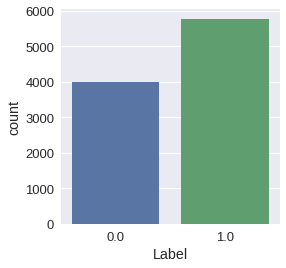

In [0]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

sns.factorplot(x="Label", data=train_data, kind="count")
plt.show();

In [0]:
def build_model():
  
#     base_model = InceptionV3(
#                           weights=None, 
#                           input_shape=(224, 224, 1), 
#                           pooling='max', 
#                           classes=1)

    
#     for layer in base_model.layers:
#         layer.trainable = True
    
    x1 = Input(shape=(224, 224, 1))
    x = Conv2D(64, kernel_size=(5, 5), activation='relu')(x1)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(500, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
    x = Activation('relu')(x)
    
    predictions = Dense(2,activation='sigmoid')(x)
    model = Model(inputs=x1, outputs=predictions)
    
    return model

In [0]:
model = build_model()
nadam=keras.optimizers.Nadam(lr=0.0002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
model.compile(loss='binary_crossentropy', optimizer=nadam, metrics=['acc', 'mse'])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 220, 220, 64)      1664      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 108, 108, 32)      18464     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 93312)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               46656500  
__________

In [0]:
NUM_SAMPLES=train_data.shape[0]
VAL_SIZE=val_data.shape[0]
BATCH_SIZE=128
NUM_EPOCHS = 10

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    zoom_range=0.2,
    rotation_range=5,
    horizontal_flip=True
)

In [0]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_data, 
    directory  = DATASET_DIR,
    x_col = "Path", 
    target_size=(224, 224),
    color_mode='grayscale', 
    class_mode='other', 
    batch_size=32
)

KeyError: ignored

In [0]:
val_datagen = ImageDataGenerator(
    rescale = 1. /255)

In [0]:
val_generator = val_datagen.flow_from_dataframe(
    dataframe = val_data, 
    directory  = DATASET_DIR, 
    x_col = "Path", 
    y_col = y_valid, 
    target_size=(224, 224),
    color_mode='grayscale', 
    class_mode='other', 
    batch_size=32
)

In [0]:
model.fit_generator(
    generator = train_generator, 
    steps_per_epoch = NUM_SAMPLES/BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1, 
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            patience=7, 
            min_delta=0.0001
        ),
        TensorBoard(
            log_dir='Graph_complete', 
            histogram_freq=0, 
            write_graph=True, 
            write_images=True
        )
    ], 
    validation_data=val_generator, 
    validation_steps = VAL_SIZE/BATCH_SIZE,
    shuffle=True
)

In [0]:
from keras.models import model_from_json
with open('arch_XR_WRIST.json','r') as f:
  model=model_from_json(f.read())
model.load_weights('weight_XR_WRIST.h5')

In [0]:
test_generator = val_datagen.flow_from_dataframe(
    dataframe = val_data, 
    directory  = DATASET_DIR, 
    x_col = "Path", 
    y_col = "Label", 
    target_size=(224, 224),
    color_mode='grayscale', 
    class_mode='other', 
    batch_size=1,
    shuffle=False
)

pred = model.predict_generator(test_generator, VAL_SIZE)

In [0]:
s = val_data.Path[0].split('/')[1:-1]
s = '/'.join(s)
count=0
avg = 0
pred_final = []
pred_actual = []
for i in range(VAL_SIZE):
  study = val_data.Path[i].split('/')[1:-1]
  study = '/'.join(study)
  if(study==s):
    avg=avg+pred[i]
    count += 1
  else:
    if count>0:
      avg = avg/count
    pred_final.append([0 if avg<0.5 else 1])
    pred_actual.append(val_labels['MURA-v1.1/'+s+'/'])
    s=study
    avg=pred[i]
    count=1
   
 

In [0]:
from sklearn.metrics import confusion_matrix

labels = np.array([0 if x>0.5 else 1 for x in pred])

confusion_matrix(np.array(val_data['Label']), labels)

In [0]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(pred_actual, pred_final)

In [0]:
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
fpr, tpr, threshold = roc_curve(val_labels,conf_labels,pos_label=0)
roc_auc = auc(fpr, tpr)

In [0]:
pred = model.predict_generator(test_generator, VAL_SIZE)

In [0]:
test_generator